# Utils
> supporting functions

In [1]:
# | default_exp utils

In [2]:
# | exporti

import os
from typing import List, Tuple, Union

import re
import pathlib
import unicodedata
import json
import chardet
from urllib.parse import urljoin, urlparse

from bs4 import BeautifulSoup
from markdownify import MarkdownConverter

import datetime as dt
import base64

import asyncio

import pptx2md
from PIL import Image

import zipfile
import io


import datetime as dt
from dateutil.parser import parse as dtu_parse

from dotenv import set_key, load_dotenv

In [3]:
# | hide
from nbdev.showdoc import show_doc
from dotenv import load_dotenv

import domolibrary_extensions.google.auth as ga


# Codespace Mangement

In [4]:
#| exports
default_keys = ['DOCKER_BUILDKIT',
 'ENABLE_DYNAMIC_INSTALL',
 'LESSOPEN',
 'GIT_COMMITTER_NAME',
 'PYTHONIOENCODING',
 'GITHUB_CODESPACE_TOKEN',
 'USER',
 'RVM_PATH',
 'NVS_ROOT',
 'HOSTNAME',
 'DOTNET_USE_POLLING_FILE_WATCHER',
 'CONDA_SCRIPT',
 'PIPX_HOME',
 'SHLVL',
 'GITHUB_CODESPACES_PORT_FORWARDING_DOMAIN',
 'GCP_KEY',
 'HUGO_ROOT',
 'HOME',
 'OLDPWD',
 'ORYX_ENV_TYPE',
 'NVM_BIN',
 'CODESPACES',
 'DOTNET_RUNNING_IN_CONTAINER',
 'NVM_SYMLINK_CURRENT',
 'DYNAMIC_INSTALL_ROOT_DIR',
 'PIPX_BIN_DIR',
 'NVM_INC',
 'rvm_stored_umask',
 'ORYX_DIR',
 'GRADLE_HOME',
 'rvm_user_install_flag',
 'MAVEN_HOME',
 'GOROOT',
 'NODE_ROOT',
 'GITHUB_GRAPHQL_URL',
 'GITHUB_USER',
 'NVM_DIR',
 'PYTHON_PATH',
 'DOTNET_SKIP_FIRST_TIME_EXPERIENCE',
 'ContainerVersion',
 'NVS_HOME',
 'GITHUB_API_URL',
 'rvm_bin_path',
 'SDKMAN_CANDIDATES_API',
 '_',
 'RUBY_VERSION',
 'PROMPT_DIRTRIM',
 'IRBRC',
 'CLOUDENV_ENVIRONMENT_ID',
 'DOTNET_ROOT',
 'NVS_DIR',
 'PHP_ROOT',
 'PATH',
 'JAVA_ROOT',
 'VSCODE_AGENT_FOLDER',
 'SDKMAN_CANDIDATES_DIR',
 'HUGO_DIR',
 'NPM_GLOBAL',
 'SHELL_LOGGED_IN',
 'MY_RUBY_HOME',
 'LANG',
 'SDKMAN_DIR',
 'RUBY_ROOT',
 'LS_COLORS',
 'SDKMAN_PLATFORM',
 'GITHUB_REPOSITORY',
 'SHELL',
 'GOPATH',
 'rvm_prefix',
 'rvm_loaded_flag',
 'GEM_HOME',
 'ORYX_PREFER_USER_INSTALLED_SDKS',
 'LESSCLOSE',
 'ORYX_SDK_STORAGE_BASE_URL',
 'CONDA_DIR',
 'rvm_version',
 'DEBIAN_FLAVOR',
 'GIT_COMMITTER_EMAIL',
 'GEM_PATH',
 'JAVA_HOME',
 'NVS_USE_XZ',
 'INTERNAL_VSCS_TARGET_URL',
 'PWD',
 'NVM_CD_FLAGS',
 'GITHUB_SERVER_URL',
 'PHP_PATH',
 'PYTHON_ROOT',
 'RAILS_DEVELOPMENT_HOSTS',
 'NVS_OS',
 'CODESPACE_NAME',
 'RUBY_HOME',
 'MAVEN_ROOT',
 'rvm_path',
 'NUGET_XMLDOC_MODE',
 'VSCODE_HANDLES_SIGPIPE',
 'VSCODE_AMD_ENTRYPOINT',
 'VSCODE_HANDLES_UNCAUGHT_ERRORS',
 'VSCODE_NLS_CONFIG',
 'BROWSER',
 'VSCODE_CWD',
 'ELECTRON_RUN_AS_NODE',
 'VSCODE_IPC_HOOK_CLI',
 'VSCODE_L10N_BUNDLE_LOCATION',
 'DEBUG',
 'PYDEVD_IPYTHON_COMPATIBLE_DEBUGGING',
 'PYTHONUNBUFFERED',
 'PYDEVD_USE_FRAME_EVAL',
 'TERM',
 'CLICOLOR',
 'FORCE_COLOR',
 'CLICOLOR_FORCE',
 'PAGER',
 'GIT_PAGER',
 'MPLBACKEND']

def export_env(
        default_keys,
        output_file_path
):
    keep_keys = [key for key in os.environ.keys() if key not in default_keys]

    with open(output_file_path , 'w+') as f:
        f.writelines([ f"{key} = '{value}'\n" for key, value in os.environ.items() if key in keep_keys])
        f.write(f"_OUTPUT_DATE = '{dt.datetime.now().strftime('%Y-%m-%d %H:%M')}'")

In [5]:
export_env(default_keys= default_keys,
           output_file_path= '../.env')

# Code Execution

In [6]:
#| export
async def gather_with_concurrency(
    *coros,  # list of coroutines to await
    n=60,  # number of open coroutines
):
    """limits the number of open coroutines at a time."""

    semaphore = asyncio.Semaphore(n)

    async def sem_coro(coro):
        async with semaphore:
            return await coro

    return await asyncio.gather(*(sem_coro(c) for c in coros))
     

# File Management

In [7]:
#|exports

def rename_filepath_to_match_datatype(data, file_path):

    is_path_ext = os.path.splitext(file_path)[-1].lower()

    old_suffix = pathlib.Path(file_path).suffix if is_path_ext else None

    new_suffix = ''

    print(type(data))

    if isinstance(data, str) or isinstance(data, bytes) or isinstance(data, bytearray) : new_suffix = '.txt'
    if isinstance(data, dict) : new_suffix = '.json'

    file_path = file_path+new_suffix
    
    if old_suffix:
        file_path = file_path.replace(old_suffix,'')

    return file_path

In [8]:
content = [ "hello world" , {"a" : "b"}, b'\xC3\xA9', bytearray(b'\x02\x03\x05\x07')]

[rename_filepath_to_match_datatype(test, "/Users/pankaj/abc") for test in content]

<class 'str'>
<class 'dict'>
<class 'bytes'>
<class 'bytearray'>


['/Users/pankaj/abc.txt',
 '/Users/pankaj/abc.json',
 '/Users/pankaj/abc.txt',
 '/Users/pankaj/abc.txt']

In [9]:
# | exports
def detect_encoding(file_path, debug_prn: bool = False):
    detector = chardet.universaldetector.UniversalDetector()
    with open(file_path, "rb") as f:
        for line in f:
            detector.feed(line)
            if detector.done:
                break
    detector.close()

    encoding = detector.result

    return encoding

In [10]:
detect_encoding("./utils.ipynb")

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}

In [11]:
# | export
def read_html_file(
    file_path, is_convert_to_soup: bool = True
) -> Union[str, BeautifulSoup]:
    if not os.path.exists(file_path):
        raise FileNotFoundError(file_path)

    page_encoding = detect_encoding(file_path)

    with open(file_path, encoding=page_encoding["encoding"]) as fp:
        if is_convert_to_soup:
            return BeautifulSoup(fp, "lxml")

        return fp.read()

# Handle URLS

In [12]:
# | exports
def remove_query_params_from_url(url):
    u = urlparse(url)
    return urljoin(url, urlparse(url).path)

In [13]:
test_urls = [
    "https://domo-support.domo.com/s/article/36004740075",
    "https://domo-support.domo.com/s/topic/0TO5w000000ZlOmGAK/20202023",  # list of articles
    "https://domo-support.domo.com/s/topic/0TO5w000000Zan7GAC/archived-feature-release-notes",  # list of topics
    "https://domo-support.domo.com/s/knowledge-base",
]

[remove_query_params_from_url(url) for url in test_urls]

['https://domo-support.domo.com/s/article/36004740075',
 'https://domo-support.domo.com/s/topic/0TO5w000000ZlOmGAK/20202023',
 'https://domo-support.domo.com/s/topic/0TO5w000000Zan7GAC/archived-feature-release-notes',
 'https://domo-support.domo.com/s/knowledge-base']

In [14]:
# | exports
def update_env(env_path: str, key: str, value: str, debug_prn: bool = False) -> dict:
    """
    updates a .env file with a key value pair
    then reloads the env_file
    """

    if not os.path.exists(env_path):
        with open(env_path, "w", encoding="utf-8") as f:
            f.write("")

    quote_mode = "always"

    if isinstance(value, dict):
        quote_mode = "never"
        value = json.dumps(value)

    if debug_prn:
        from pprint import pprint

        pprint(
            {
                "env_path": env_path,
                "key": key,
                "value": value,
                "type": type(value),
                "quote_mode": quote_mode,
            }
        )

    set_key(env_path, key, value, quote_mode=quote_mode)

    set_key(env_path, "env_last_modified", f"updated - {dt.date.today()}")

    load_dotenv(env_path, override=True)

    return {key: os.getenv(key)}

In [15]:
# | exports
def upsert_folder(folder_path: str, debug_prn: bool = False):
    folder_path = os.path.dirname(folder_path)

    if debug_prn:
        print(
            {
                "upsert_folder": os.path.abspath(folder_path),
                "is_exist": os.path.exists(folder_path),
            }
        )

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [16]:
# |exports


def get_all_files_and_folders(
    directory, file_type=None  # to only retrieve a specific file type
) -> Union[Tuple, List]:
    """walk a directory and retrieve a list of files and a list of directory
    returns Tuple of file_ls , dir_ls OR file_ls if file_type supplied
    """
    if not os.path.exists(directory):
        raise FileNotFoundError(directory)

    file_ls = []
    dir_ls = []
    for root, dirs, files in os.walk(directory):
        for name in files:
            if file_type:
                if not name.lower().endswith(file_type.lower()):
                    continue
            file_ls.append(os.path.join(root, name))

        if file_type:
            continue

        for name in dirs:
            dir_ls.append(os.path.join(root, name))

    if file_type:
        return file_ls

    return file_ls, dir_ls

In [17]:
# Use the function
get_all_files_and_folders("./jira", ".json")

['./jira/CACHE/onyxreporting_atlassian_net/rest/agile/1_0/board.json',
 './jira/CACHE/onyxreporting_atlassian_net/rest/agile/1_0/epic/10002.json',
 './jira/CACHE/onyxreporting_atlassian_net/rest/agile/1_0/board/1.json',
 './jira/CACHE/onyxreporting_atlassian_net/rest/agile/1_0/board/3/epic.json',
 './jira/CACHE/onyxreporting_atlassian_net/rest/agile/1_0/board/3/issue.json',
 './jira/CACHE/onyxreporting_atlassian_net/rest/api/2/myself.json']

## handle converting Files to Markdown

In [20]:
# export

def read_image_from_file(image_path, return_base64 :bool = False) -> Union[Image.Image, bytes]:
    if not os.path.exists(image_path):
        raise FileNotFoundError(image_path)
        

    with open(image_path, "rb") as image_file:
        data = base64.b64encode(image_file.read())

        if return_base64:
            return data

        im = Image.open(io.BytesIO(base64.b64decode(data)))
        return im
    


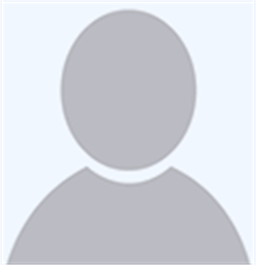

In [22]:
read_image_from_file('./TEST/icon.png', return_base64=False)

In [ ]:
# | exports


class ImageBlockConverter(MarkdownConverter):
    """
    Create a custom MarkdownConverter that adds two newlines after an image
    """

    def convert_img(self, el, text, convert_as_inline, is_resize: bool = True):
        """
        custom image downloader for ImabeBlockConverter
        will handle resize
        """

        if is_resize:
            style_obj = {
                (obj.split(":")[0].strip()): obj.split(":")[1].strip()
                for obj in el.get("style").split(";")
                if ":" in obj
            }

            file_path = os.path.join(
                os.path.dirname(self.options["file_path"]), el["src"]
            )

            image = Image.open(file_path)

            width = style_obj["width"].replace("px", "")
            width = int(float(width))

            height = style_obj["height"].replace("px", "")
            height = int(float(height))

            new_image = image.resize((width, height))
            new_image.save(file_path)

        return super().convert_img(el, text, convert_as_inline)


def md(html, **options):
    """Create shorthand method for handling conversion"""
    return ImageBlockConverter(**options).convert(html)

In [ ]:
# |exports
def convert_html_to_markdown(file_path):
    """converts html file to markdown in place"""

    with open(file_path, encoding="utf-8") as f:
        html = f.read()

    markdown_content = md(
        str(html),
        keep_inline_images_in=["td", "span"],
        file_path=file_path,
        is_resize=True,
    )

    md_path = file_path.replace(".html", ".md")

    with open(md_path, "w+", encoding="utf-8") as f:
        f.write(markdown_content)

    return

In [ ]:
# | exports


def download_zip(zip_bytes_content, output_folder, is_convert_to_markdown: bool = True):
    """save bytes content to a zip file then convert html to markdown"""

    zip = zipfile.ZipFile(io.BytesIO(zip_bytes_content), "r")
    zip.extractall(output_folder)

    file_ls = os.listdir(output_folder)

    # rename the html file to index.html
    for file_name in file_ls:
        if file_name.endswith(".html"):
            output_index = os.path.join(output_folder, "index.html")
            os.replace(os.path.join(output_folder, file_name), output_index)

            if is_convert_to_markdown:
                convert_html_to_markdown(os.path.join(output_folder, "index.html"))

    return f"successfully downloaded zip to {output_folder}"

#### sample implementation of downloading a zip from google docs and converting it to markdown

In [ ]:
# import domolibrary_extensions.google.auth as ga

DOCUMENT_ID = "1j7XsbvFy0xUgGL6i-3LSChKvzSmTZSOyimEt6tQS-Kk"

# generates Credentials object
google_auth = ga.GoogleAuth.get_creds_from_env(
    credentials_env_key="GDOC_KEY",
    token_env_key="GDOC_TOKEN",
)
google_auth
content = (
    google_auth.service.files()
    .export(fileId=DOCUMENT_ID, mimeType="application/zip")
    .execute()
)

download_zip(content, "../TEST/utils/drive_converter-download_zip")

using saved token
refreshing creds using saved token
('invalid_grant: Bad Request', {'error': 'invalid_grant', 'error_description': 'Bad Request'})


RefreshError: ('invalid_grant: Bad Request', {'error': 'invalid_grant', 'error_description': 'Bad Request'})

In [ ]:
# |exports


def download_pptx(
    pptx_bytes_content, output_folder, is_convert_to_markdown: bool = True
):
    """save bytes content to a pptx file then converts to markdown"""

    upsert_folder(output_folder)

    output_ppt_index = os.path.join(output_folder, "index.pptx")

    with open(output_ppt_index, "wb+") as binary_file:
        # Write bytes to file
        binary_file.write(pptx_bytes_content)

    if is_convert_to_markdown:
        pptx2md.convert(
            output_ppt_index,
            output=os.path.join(output_folder, "index.md"),
            image_dir=os.path.join(output_folder, "images"),
        )

    return f"successfully downloaded content to {output_folder}"

#### sample implementation of download pptx from google drive

In [ ]:
# | import domolibrary_extensions.google.auth as ga

SLIDE_ID = "1_k4NRraKI1TmHNlpQCuqJrWr6dP7DNracdMCtfN8XlM"

# generates Credentials object
google_auth = ga.GoogleAuth.get_creds_from_env(
    credentials_env_key="GDOC_KEY", token_env_key="GDOC_TOKEN"
)

content = (
    google_auth.service.files()
    .export(
        fileId=SLIDE_ID,
        mimeType="application/vnd.openxmlformats-officedocument.presentationml.presentation",
    )
    .execute()
)
download_pptx(content, "./TEST/utils/drive_converter-download_pptx")

using saved token
generating service object on GoogleAuth


Converting slides: 100%|██████████| 2/2 [00:00<00:00, 1045.18it/s]


'successfully downloaded content to ./TEST/utils/drive_converter-download_pptx'

# Text Cleaning

In [ ]:
# | exports
def convert_str_to_snake_case(text_str):
    """converts 'snake_case_str' to 'snakeCaseStr'"""

    return text_str.replace(" ", "_").lower()

In [ ]:
# | exports
def convert_str_remove_accents(text_str: str) -> str:
    return "".join(
        c
        for c in unicodedata.normalize("NFD", text_str)
        if unicodedata.category(c) != "Mn"
    )

In [ ]:
convert_str_remove_accents("est être"), convert_str_remove_accents("kožušček")

('est etre', 'kozuscek')

In [ ]:
# | exports
def convert_str_keep_alphanumeric(text_str) -> str:
    pattern = "[^0-9a-zA-Z_\s]+"

    return re.sub(pattern, "", text_str)

In [ ]:
# | exports
def convert_str_file_name(text_str: str) -> str:
    """convert strings to clean file name or url"""

    return convert_str_keep_alphanumeric(
        convert_str_to_snake_case(convert_str_remove_accents(text_str))
    )

In [ ]:
convert_str_file_name("Register Snowflake with Cloud Amplifier"), convert_str_file_name(
    "Kožušček and Beast Modes"
)

('register_snowflake_with_cloud_amplifier', 'kozuscek_and_beast_modes')

# Conversion

In [ ]:
# | exports
def convert_str_to_date(datefield: str) -> dt.datetime:
    """converts string date to datetime object"""
    return dtu_parse(datefield) if datefield else None

In [ ]:
convert_str_to_date("2023-10-01")

datetime.datetime(2023, 10, 1, 0, 0)

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export("utils.ipynb")